# PRIMO 2022 ML Homework 4<br>
### Estimating the issue priority in the bug tracker

Задача: предсказать, имеет ли проблема высокий приоритет, учитывая ее описание и метаданные.<br>
Данные: взяты с сайта youtrack.jetbrains.com.<br>
Оценка качества: F1 мера

Метрика оценки качества для соревнования: F1 мера для класса 1.<br>
<br>
**Формат файла с предсказаниями<br>**
Для каждой задачи в наборе test итоговый файл с предсказаниями должен содержать два значения: id (id задачи, взятый из столбца `id` в наборе данных test) и предсказание приоритета задачи (1, если приоритет высокий, или 0, если приоритет низкий).<br>
<br>
Файл должен иметь заголовок и следующий формат:<br>
<br>
id,is_high_priority<br>
0,1<br>
1,1<br>
2,1<br>

In [137]:
import pandas as pd
import numpy as np

import warnings
import json
import operator

from tqdm import tqdm

from sklearn.model_selection import train_test_split


from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.naive_bayes import MultinomialNB


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
#np.set_printoptions(precision=3)
#pd.set_option('precision', 3)



In [3]:
dataFrameMapper_data = pd.read_csv('test.csv', index_col='id')

In [4]:
train_data = pd.read_csv('train.csv', index_col='id')

In [5]:
train_data1=train_data

In [6]:
#train_data1 = train_data.sample(frac = 1)
#chunks = np.array_split(train_data1, 10)
#train_data1 = chunks[0]

In [7]:
train_data1.summary.fillna('', inplace=True)
train_data1.description.fillna('', inplace=True)


In [8]:
dataFrameMapper_data.summary.fillna('', inplace=True)
dataFrameMapper_data.description.fillna('', inplace=True)

In [9]:
json_fields = pd.json_normalize(train_data1.customFields.map(json.loads).map(lambda x: {field['name']: field['value'] for field in x}))
json_fields.set_index(train_data1.index, inplace=True)
json_fields.fillna('',inplace=True)



In [10]:
json_fields['Subsystem.name'].value_counts()

                                     22587
User Interface                        6840
Editor. Editing Text                  4038
Lang. Flash and Flex                  3516
Build. Maven                          3420
                                     ...  
No Subsystem                             1
User Interface. Search Everywhere        1
Core. Licensing                          1
Frameworks. Micronaut                    1
User Interface. Plugins                  1
Name: Subsystem.name, Length: 177, dtype: int64

In [11]:
json_columns = ['Type.name','State.name','Subsystem.name','Assignee.login']
train_data1 = train_data1.join(json_fields[json_columns], how='outer', lsuffix='_left')


train_data1['reporter_name'] = train_data1.reporter.map(json.loads).map(operator.itemgetter('login'))
train_data1['Year'] = train_data1.created.apply(lambda c: pd.to_datetime(c, unit='ms').year)
train_data1['Month'] = train_data1.created.apply(lambda c: pd.to_datetime(c, unit='ms').month)
train_data1['Day'] = train_data1.created.apply(lambda c: pd.to_datetime(c, unit='ms').day)
train_data1['Hour'] = train_data1.created.apply(lambda c: pd.to_datetime(c, unit='ms').hour)
prep_train_data = train_data1.drop(labels=['reporter', 'created', 'customFields', 'links'], axis=1)

In [12]:
prep_train_data

,summary,description,is_high_priority,Type.name,State.name,Subsystem.name,Assignee.login,reporter_name,Year,Month,Day,Hour
id,,,,,,,,,,,,
25-60681,Don't sync font size within IDEA server plugin,At home I have 1900x1200 resolution and at my ...,False,Bug,Obsolete,Core. Project Settings,lesya,machak,2009,1,5,10
25-60682,Cancelling subversion update,When cancelling an update from ie. subversion ...,False,Usability Problem,Obsolete,Version Control. Subversion,Kirill.Likhodedov,sprice,2009,1,5,10
25-60686,Suspended Breakpoint in JVM not Recognized in ...,In some breakpoint cases for a app launched fr...,False,Bug,Duplicate,Java. Debugger,jeka,brigham,2009,1,5,19
25-60691,Good code red: IDEA incorrectly resolves neste...,The relevant snippet if part of the UIDebug cl...,False,Bug,Obsolete,Code Analysis. Inspection,cdr,xduke,2009,1,6,11
25-60679,Module WIll Not Load Jar Dependencies on Intre...,I have IntelliJ 7.0.5 running on both WIndows ...,False,Bug,Fixed,Core. Project Settings,sashache,stonemack,2009,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...
25-2507313,Version Control Incoming tab missing search fi...,"The Version Control tab for ""Incoming"" doesn't...",False,Usability Problem,Submitted,Version Control. Subversion,konstantin.kolosovsky,markhodgson,2019,9,26,10
25-2507159,Groovy compiler can't find files with names co...,1. Create a new Project with groovy support\n2...,False,Bug,Duplicate,,,ted.lundqvist,2019,9,26,9
25-2507096,auto close stepped in files on debug resume,"Hi,\n\none coworker switched from eclipse to I...",False,Feature,Duplicate,Java. Debugger,egor,alain57,2019,9,26,8


In [13]:
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re

In [14]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\WildGoose\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WildGoose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\WildGoose\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

*сначала происходит лемматизация слов, и потом они отфильтровываются по условиям, так работать не должно*

In [15]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
       return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if re.fullmatch(r'[A-Za-z]{4,}', t) and t not in STOP_WORDS]

In [16]:
X_train_text = prep_train_data.summary.astype(str) + " " + prep_train_data.description.astype(str)


In [17]:
X_train_text

id
25-60681      Don't sync font size within IDEA server plugin...
25-60682      Cancelling subversion update When cancelling a...
25-60686      Suspended Breakpoint in JVM not Recognized in ...
25-60691      Good code red: IDEA incorrectly resolves neste...
25-60679      Module WIll Not Load Jar Dependencies on Intre...
                                    ...                        
25-2507313    Version Control Incoming tab missing search fi...
25-2507159    Groovy compiler can't find files with names co...
25-2507096    auto close stepped in files on debug resume Hi...
25-2506900    Keymaps don't resync after disabled settings s...
25-2506947    OK , cancel button do not appear when i do imp...
Length: 105365, dtype: object

In [18]:
tfidf_vec_summary = TfidfVectorizer(min_df=.01, max_df=0.75,
                                    tokenizer=LemmaTokenizer(),
                             )
tfidf_vec_summary.fit(X_train_text)
train_text_prep = pd.DataFrame(tfidf_vec_summary.transform(X_train_text).todense(), index=X_train_text.index,
                               columns=tfidf_vec_summary.get_feature_names_out())
train_text_prep



c:\users\wildgoose\.virtualenvs\data science\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,ability,able,access,action,active,actual,actually,added,adding,additional,...,warning,webstorm,window,word,work,workaround,worked,working,write,wrong
id,,,,,,,,,,,,,,,,,,,,,
25-60681,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.342789,0.000000,0.000000,0.153148,0.0,0.0
25-60682,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25-60686,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25-60691,0.0,0.0,0.292776,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25-60679,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.218506,0.0,0.057511,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25-2507313,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25-2507159,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.185462,0.000000,0.0,0.0
25-2507096,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.051002,0.092807,0.000000,0.000000,0.0,0.0


In [62]:
Y = prep_train_data['is_high_priority']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(train_text_prep, Y,
                                                    stratify=Y,
                                                    random_state=3,
                                                    test_size=0.25,
                                                    shuffle=True)

In [ ]:
selector = SelectKBest(f_regression, k=2)

selector.fit(X_train, y_train)

print(selector.scores_)

selector.transform(X_train)

AttributeError: 'numpy.ndarray' object has no attribute 'get_support'

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel


clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(train_text_prep, Y)


model = SelectFromModel(clf, prefit=True)
X_new = model.transform(train_text_prep)
X_new.shape

In [81]:
clf.feature_importances_

array([0.00070454, 0.00206905, 0.00125155, 0.00284044, 0.00102024,
       0.00131813, 0.00109432, 0.00236635, 0.0014601 , 0.00159358,
       0.00144552, 0.00653666, 0.00154154, 0.00147809, 0.00183275,
       0.00182298, 0.00252092, 0.00299888, 0.00085365, 0.00173259,
       0.00051218, 0.00151757, 0.00072571, 0.00167633, 0.00176451,
       0.00544828, 0.00081109, 0.00112624, 0.00177817, 0.00139508,
       0.0017646 , 0.00209076, 0.0010673 , 0.00129914, 0.00081451,
       0.00077414, 0.00144696, 0.00088802, 0.00082948, 0.00119642,
       0.00037112, 0.00186002, 0.00163215, 0.00254576, 0.00668245,
       0.00161656, 0.00306094, 0.00166274, 0.00137761, 0.00102862,
       0.0023196 , 0.00251277, 0.00233343, 0.005857  , 0.00212485,
       0.00105742, 0.00158373, 0.00209396, 0.00083945, 0.00174219,
       0.0015707 , 0.00463071, 0.00101194, 0.00115137, 0.0033811 ,
       0.00167748, 0.00089304, 0.00260808, 0.00174662, 0.00140778,
       0.00735766, 0.00129578, 0.0008275 , 0.00091031, 0.00218

Automatically created module for IPython interactive environment


c:\users\wildgoose\.virtualenvs\data science\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
c:\users\wildgoose\.virtualenvs\data science\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
c:\users\wildgoose\.virtualenvs\data science\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
c:\users\wildgoose\.virtualenvs\data science\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' val

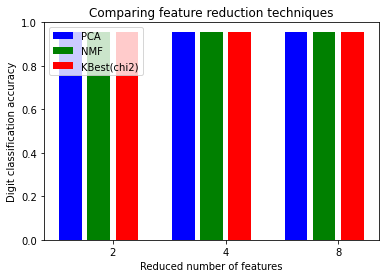

In [68]:



print(__doc__)

pipe = Pipeline([
    # этап reduce_dim заполняется параметром param_grid
    ('reduce_dim', 'passthrough'),
    ('classify', LinearSVC(dual=False, max_iter=10000))
])

N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# баллов в порядке итерации param_grid, что в алфавитном порядке.
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# выберите балл для лучшего C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

plt.show()

In [21]:
prep_train_data = prep_train_data.drop(['summary','description'], axis=1)

In [22]:
prep_train_data = prep_train_data.join(train_text_prep)

In [23]:
prep_train_data

,is_high_priority,Type.name,State.name,Subsystem.name,Assignee.login,reporter_name,Year,Month,Day,Hour,...,warning,webstorm,window,word,work,workaround,worked,working,write,wrong
id,,,,,,,,,,,,,,,,,,,,,
25-60681,False,Bug,Obsolete,Core. Project Settings,lesya,machak,2009,1,5,10,...,0.0,0.0,0.000000,0.0,0.342789,0.000000,0.000000,0.153148,0.0,0.0
25-60682,False,Usability Problem,Obsolete,Version Control. Subversion,Kirill.Likhodedov,sprice,2009,1,5,10,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25-60686,False,Bug,Duplicate,Java. Debugger,jeka,brigham,2009,1,5,19,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25-60691,False,Bug,Obsolete,Code Analysis. Inspection,cdr,xduke,2009,1,6,11,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25-60679,False,Bug,Fixed,Core. Project Settings,sashache,stonemack,2009,1,5,5,...,0.0,0.0,0.218506,0.0,0.057511,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25-2507313,False,Usability Problem,Submitted,Version Control. Subversion,konstantin.kolosovsky,markhodgson,2019,9,26,10,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25-2507159,False,Bug,Duplicate,,,ted.lundqvist,2019,9,26,9,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.185462,0.000000,0.0,0.0
25-2507096,False,Feature,Duplicate,Java. Debugger,egor,alain57,2019,9,26,8,...,0.0,0.0,0.000000,0.0,0.051002,0.092807,0.000000,0.000000,0.0,0.0


In [ ]:
#pd.options.display.max_rows = 200



tfidf_vec_desc = TfidfVectorizer(min_df=.01, max_df=0.5,
                                   # token_pattern=r'[A-Za-z]{2,}',
                                    tokenizer=LemmaTokenizer(),
                                    stop_words=STOP_WORDS)
tfidf_vec_desc.fit(X_train_description)
X_train_description_sample = pd.DataFrame(tfidf_vec_desc.transform(X_train_description).todense(),
                                          columns=tfidf_vec_desc.get_feature_names_out())
X_train_description_sample

In [ ]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

\# todo сократить размерность. Лемматизация, регулярные выражения поумнее, пороги для векторизации, объединить слова описания и заголовка?
отбор признаков по модели

In [27]:
from sklearn_pandas import DataFrameMapper

preprocessor = DataFrameMapper([
                                (['Type.name'], OneHotEncoder(sparse=False, handle_unknown='ignore')),
                                (['reporter_name'], OneHotEncoder(sparse=False, handle_unknown='ignore')),
                                (['Subsystem.name'], OneHotEncoder(sparse=False, handle_unknown='ignore')),
                                ('Year', None),
                                ('Month', None),
                                ('Day', None),
                                ('Hour', None),
                                ],
                               input_df=True,
                               df_out=True)



In [30]:
oneHotEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [28]:
X, Y = prep_train_data.drop(['is_high_priority'], axis=1), prep_train_data['is_high_priority']


In [50]:

X_ohe = pd.get_dummies(X,prefix=['Type'], columns = ['Type.name'], drop_first=True)
X_ohe = pd.get_dummies(X,prefix=['Subsysytem'], columns = ['Subsystem.name'], drop_first=True)
X_ohe = pd.get_dummies(X,prefix=['State'], columns = ['State.name'], drop_first=True)
X_ohe = pd.get_dummies(X,prefix=['Assignee'], columns = ['Assignee.login'], drop_first=True)
X_ohe = pd.get_dummies(X,prefix=['Reporter'], columns = ['reporter_name'], drop_first=True)

In [56]:
X_ohe=X_ohe.drop(['Type.name','State.name','Subsystem.name','Assignee.login'], axis=1)

,Type.name,State.name,Subsystem.name,Assignee.login,Year,Month,Day,Hour,ability,able,...,Reporter_杨.轲,Reporter_杰.王,Reporter_耿_章,Reporter_誠樹.山本,Reporter_鑫.肇,Reporter_雷.焦,Reporter_震_田,Reporter_강우_이,Reporter_성호.이,Reporter_주희_이
id,,,,,,,,,,,,,,,,,,,,,
25-60681,Bug,Obsolete,Core. Project Settings,lesya,2009,1,5,10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
25-60682,Usability Problem,Obsolete,Version Control. Subversion,Kirill.Likhodedov,2009,1,5,10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
25-60686,Bug,Duplicate,Java. Debugger,jeka,2009,1,5,19,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
25-60691,Bug,Obsolete,Code Analysis. Inspection,cdr,2009,1,6,11,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
25-60679,Bug,Fixed,Core. Project Settings,sashache,2009,1,5,5,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25-2507313,Usability Problem,Submitted,Version Control. Subversion,konstantin.kolosovsky,2019,9,26,10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
25-2507159,Bug,Duplicate,,,2019,9,26,9,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
25-2507096,Feature,Duplicate,Java. Debugger,egor,2019,9,26,8,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
#dataFrameMapper_data = preprocessor.fit_transform(X)


c:\users\wildgoose\.virtualenvs\data science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\users\wildgoose\.virtualenvs\data science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\users\wildgoose\.virtualenvs\data science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


MemoryError: Unable to allocate 23.1 GiB for an array with shape (105365, 29468) and data type float64

In [ ]:
#dataFrameMapper_data.to_csv('dataMapperData.csv')

In [ ]:
#Y = Y.astype(np.int8)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe, Y,
                                                    stratify=Y,
                                                    random_state=3,
                                                    test_size=0.25,
                                                    shuffle=True)

In [ ]:
LinearSVC()

In [ ]:
SVC()

In [ ]:

param_grid = dict(threshold=[.05,.0023, 0.01, 0.07, 0.08], selector = [LogisticRegression(),KNeighborsClassifier(n_neighbors=2),ExtraTreesClassifier()] )

resultsProba = []
for params in tqdm(ParameterGrid(param_grid)):

    clf = Pipeline([
        ('feature_selection', SelectFromModel(LinearSVC())),
        ('classification', params['selector'])
    ])
    clf.fit(X_train, y_train)

    resultsProba.append(dict(
                        parameters=params,
                        train_f1 = f1_score(y_true=y_train, y_pred=clf.predict_proba(X_train)[:,1] > params['threshold']),
                        test_f1 = f1_score(y_true=y_test, y_pred=clf.predict_proba(X_test)[:,1] > params['threshold']),

    ))

 50%|█████     | 10/20 [41:34<41:34, 249.41s/it]


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(resultsProba).sort_values('test_f1').style.bar(vmin=0, vmax=1)

In [139]:
pred = clf.predict_proba(X_test)[:,1]

In [153]:
threshold = 0.07
f1_score(y_true=y_test, y_pred= pred > threshold)

0.1226158038147139

In [ ]:
# https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge, PassiveAggressiveRegressor, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, MultinomialNB, ComplementNB

In [58]:
from sklearn.preprocessing import StandardScaler

std_scaler = MinMaxScaler()

X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

X_train_scaled

MemoryError: Unable to allocate 17.6 GiB for an array with shape (29816, 79023) and data type float64

# todo надо бужет скэйлить!
from sklearn.ensemble import RandomForestRegressor
clf = SGDClassifier()

clf.fit(X_train_scaled,y_train)

In [59]:
SVC_model = SVC()
# В KNN-модели нужно указать параметр n_neighbors
# Это число точек, на которое будет смотреть
# классификатор, чтобы определить, к какому классу принадлежит новая точка
KNN_model = KNeighborsClassifier(n_neighbors=5)
RFC_model = RandomForestClassifier()

SVC_model.fit(X_train, y_train)
KNN_model.fit(X_train, y_train)
RFC_model.fit(X_train, y_train)

SVC_prediction = SVC_model.predict(X_test)
KNN_prediction = KNN_model.predict(X_test)
RFC_model = RandomForestClassifier.predict_proba(X_test)[:,1]

MemoryError: Unable to allocate 17.6 GiB for an array with shape (29816, 79023) and data type float64

In [ ]:
logReg = KNeighborsClassifier(n_neighbors=2)
logReg.fit(X_train_scaled, y_train)

In [ ]:
predictions = logReg.predict(X_test_scaled)

In [ ]:
proba = logReg.predict_proba(X_test_scaled)[:, 1]

In [ ]:
threshold = 0.03
f1_score(y_true=y_test, y_pred=proba > threshold)

In [230]:
f1_score(y_true=y_test, y_pred=KNN_prediction)

0.0

In [232]:
param_grid = dict(threshold=[.1, .2, .3, .4, .5, .01,.005, .05, .001,.0023, 0.003])

resultsProba = []
for params in tqdm(ParameterGrid(param_grid)):

  #  prediction = logReg.predict_proba(X_test_scaled)[:,1]
    resultsProba.append(dict(
                        parameters=params,
                        train_f1 = f1_score(y_true=y_train, y_pred=logReg.predict_proba(X_train_scaled)[:,1] > params['threshold']),
                        test_f1 = f1_score(y_true=y_test, y_pred=logReg.predict_proba(X_test_scaled)[:,1] > params['threshold']),

    ))


100%|██████████| 11/11 [00:58<00:00,  5.35s/it]


In [ ]:
param_grid = dict(threshold=[.1, .2, .3, .4, .5, .01,.005, .05, .001,.0023, 0.003])

resultsProba = []
for params in tqdm(ParameterGrid(param_grid)):

  #  prediction = logReg.predict_proba(X_test_scaled)[:,1]
    resultsProba.append(dict(
                        parameters=params,
                        train_f1 = f1_score(y_true=y_train, y_pred=logReg.predict_proba(X_train_scaled)[:,1] > params['threshold']),
                        test_f1 = f1_score(y_true=y_test, y_pred=logReg.predict_proba(X_test_scaled)[:,1] > params['threshold']),

    ))


In [223]:
pd.DataFrame(resultsProba).sort_values('test_f1').style.bar(vmin=0, vmax=1)

,parameters,train_f1,test_f1
0,{'threshold': 0.1},0.000000,0.000000
1,{'threshold': 0.2},0.000000,0.000000
2,{'threshold': 0.3},0.000000,0.000000
3,{'threshold': 0.4},0.000000,0.000000
4,{'threshold': 0.5},0.000000,0.000000
7,{'threshold': 0.05},0.016901,0.000000
10,{'threshold': 0.03},0.060606,0.032787
5,{'threshold': 0.01},0.245283,0.051282
6,{'threshold': 0.005},0.381119,0.099617
9,{'threshold': 0.0023},0.324222,0.114286




prediction = clf.predict_proba(X_test)[:,1]
#print (f'Test f1 = {f1_score(y_true=y_test, y_pred=nb_pipeline.predict(X_test))}')

prediction

score = clf.score(X_test, y_test)
score

In [68]:
X_test

,Type.name_x0_Auto-reported Exception,Type.name_x0_Bug,Type.name_x0_Configuration Problem,Type.name_x0_Cosmetics,Type.name_x0_Exception,Type.name_x0_Feature,Type.name_x0_Meta Issue,Type.name_x0_Performance Problem,Type.name_x0_Security Problem,Type.name_x0_Support Request,...,Subsystem.name_x0_Version Control. Log,Subsystem.name_x0_Version Control. Mercurial,Subsystem.name_x0_Version Control. Perforce,Subsystem.name_x0_Version Control. StarTeam (archived),Subsystem.name_x0_Version Control. Subversion,Subsystem.name_x0_Version Control. TFS (archived),Year,Month,Day,Hour
id,,,,,,,,,,,,,,,,,,,,,
25-678404,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2014,3,18,11
25-1269972,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2016,7,29,13
25-558464,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2013,5,23,20
25-643012,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2013,12,5,16
25-496273,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2012,12,17,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25-1505820,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2017,4,6,14
25-1476543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2017,3,14,9
25-2254722,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019,2,19,16


In [79]:

minMaxTest_Y = prep_train_data.is_high_priority

In [84]:
test_minMaxdf_X = prep_train_data.summary.astype(str) + " " + prep_train_data.description.astype(str)

In [85]:
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(test_minMaxdf_X, minMaxTest_Y,
                                                    stratify=Y,
                                                    random_state=3,
                                                    test_size=0.25,
                                                    shuffle=True)

In [86]:
X_train_minmax

id
25-1243311    URLs with dashes are not rendered correctly in...
25-2428876    Line change popup too small to read What steps...
25-381171     Starting an OSGi run configuration rebuilds al...
25-1437460    Terminal stop execution of process with shortc...
25-150873     Flex: If a Main.mxml is located in multiple im...
                                    ...                        
25-168009     Generate Persistence Mapping doesn't generate ...
25-1402011    Imports Added for Classes in Same Package The ...
25-653003     Unable to open .out file with IDEA 13.0.1 Step...
25-729866     Alternative "added line" visual The current po...
25-713119     sql: provide "qualify column" intention If col...
Length: 7902, dtype: object

In [94]:
from sklearn.ensemble import RandomForestRegressor
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge, PassiveAggressiveRegressor, SGDClassifier
param_grid = dict(min_df=[0.005, 0.01,.05, 0.06], max_df=[.5,.6,.7,.8], classifier=[ComplementNB(),LogisticRegression()], threshold=[.15,.05, 0.1])

results = []

for params in tqdm(ParameterGrid(param_grid)):
#     print(params)
    pipe = Pipeline(steps = [ ('tfid', TfidfVectorizer(min_df= params['min_df'], max_df= params['max_df'],
                                    tokenizer=LemmaTokenizer(),
                             )),
                             ('to_dense', DenseTransformer()),
                             ('clf',  params['classifier'])
                            ]
                       )

    #cv_train_preds = cross_val_predict(pipe, X_text_train, y_train, cv = 5, n_jobs = -1)

    pipe.fit(X_train_minmax, y_train_minmax)


    probabilitiesText1 = pipe.predict_proba(X_train_minmax)[:, 1]
    probabilitiesText2 = pipe.predict_proba(X_test_minmax)[:, 1]

    results.append(dict(
                        parameters=params,
                        train_f1 = f1_score(y_true=y_train, y_pred=probabilitiesText1 > params['threshold']),
                        test_f1 = f1_score(y_true=y_test, y_pred=probabilitiesText2 > params['threshold'])
    ))


  0%|          | 0/96 [00:00<?, ?it/s]c:\users\wildgoose\.virtualenvs\data science\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\users\wildgoose\.virtualenvs\data science\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\users\wildgoose\.virtualenvs\data science\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/do

In [95]:
pd.DataFrame(results).sort_values('test_f1').style.bar(vmin=0, vmax=1)

,parameters,train_f1,test_f1
93,"{'classifier': LogisticRegression(), 'max_df': 0.8, 'min_df': 0.06, 'threshold': 0.15}",0.000000,0.000000
81,"{'classifier': LogisticRegression(), 'max_df': 0.7, 'min_df': 0.06, 'threshold': 0.15}",0.000000,0.000000
57,"{'classifier': LogisticRegression(), 'max_df': 0.5, 'min_df': 0.06, 'threshold': 0.15}",0.000000,0.000000
69,"{'classifier': LogisticRegression(), 'max_df': 0.6, 'min_df': 0.06, 'threshold': 0.15}",0.000000,0.000000
75,"{'classifier': LogisticRegression(), 'max_df': 0.7, 'min_df': 0.01, 'threshold': 0.15}",0.158508,0.014085
87,"{'classifier': LogisticRegression(), 'max_df': 0.8, 'min_df': 0.01, 'threshold': 0.15}",0.158508,0.014085
51,"{'classifier': LogisticRegression(), 'max_df': 0.5, 'min_df': 0.01, 'threshold': 0.15}",0.158508,0.014085
63,"{'classifier': LogisticRegression(), 'max_df': 0.6, 'min_df': 0.01, 'threshold': 0.15}",0.158508,0.014085
84,"{'classifier': LogisticRegression(), 'max_df': 0.8, 'min_df': 0.005, 'threshold': 0.15}",0.166667,0.014184
60,"{'classifier': LogisticRegression(), 'max_df': 0.6, 'min_df': 0.005, 'threshold': 0.15}",0.166667,0.014184


In [ ]:
pd.DataFrame(results).drop(columns='estimator').sort_values('test_f1').style.bar(vmin=0, vmax=1)

In [71]:


#param_grid = dict(classifier=[ComplementNB(),LogisticRegression(),LinearRegression(), RandomForestRegressor()])




nb_pipeline = Pipeline(steps = [('scaler', MinMaxScaler()),
                                ('clf', ComplementNB())
                               ]
                       )

nb_pipeline.fit(X_train, y_train)

print (f'Train f1 = {f1_score(y_true=y_train, y_pred=nb_pipeline.predict(X_train))}')
print (f'Test f1 = {f1_score(y_true=y_test, y_pred=nb_pipeline.predict(X_test))}')

Train f1 = 0.039106145251396655
Test f1 = 0.0


In [74]:
param_grid = dict(threshold=[.1, .2, .3, .4, .5, .01,.005, .05])

results = []
for params in tqdm(ParameterGrid(param_grid)):
    probabilities1 = nb_pipeline.predict_proba(X_train)[:, 1]
    probabilities2 = nb_pipeline.predict_proba(X_test)[:, 1]
    results.append(dict(
                        parameters=params,
                        train_f1 = f1_score(y_true=y_train, y_pred=probabilities1 > params['threshold']),
                        test_f1 = f1_score(y_true=y_test, y_pred=probabilities2 > params['threshold'])
    ))



100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


In [76]:
pd.DataFrame(results).sort_values('test_f1').style.bar(vmin=0, vmax=1)

,parameters,train_f1,test_f1
2,{'threshold': 0.3},0.106667,0.000000
3,{'threshold': 0.4},0.055402,0.000000
4,{'threshold': 0.5},0.039106,0.000000
1,{'threshold': 0.2},0.214286,0.072727
6,{'threshold': 0.005},0.119097,0.099849
5,{'threshold': 0.01},0.150280,0.108075
7,{'threshold': 0.05},0.351906,0.147482
0,{'threshold': 0.1},0.355848,0.156134


In [ ]:


from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge, PassiveAggressiveRegressor, SGDClassifier
param_grid = dict(min_df=[0.01, .05], max_df=[.7, .8], scaler=[MinMaxScaler()])

results = []

for params in tqdm(ParameterGrid(param_grid)):
#     print(params)
    pipe = Pipeline(steps = [
        ('scaler', params['scaler']),
                             ('clf', ComplementNB())
                            ]
                       )

    #cv_train_preds = cross_val_predict(pipe, X_text_train, y_train, cv = 5, n_jobs = -1)

    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_test)

    results.append(dict(
                        estimator=pipe,
                        parameters=params,
                        train_f1 = f1_score(y_true=y_train, y_pred=pipe.predict(X_train)),
                        test_f1 = f1_score(y_true=y_test, y_pred=pipe.predict(X_test))
    ))


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge, PassiveAggressiveRegressor, SGDClassifier
param_grid = dict(min_df=[0.01, .05], max_df=[.7, .8])

results = []

for params in tqdm(ParameterGrid(param_grid)):
#     print(params)
    pipe = Pipeline(steps = [('tfidf', TfidfVectorizer(min_df=params['min_df'], max_df=params['max_df'],
                                                       token_pattern=r'[A-Za-z]{2,}',
                                                       stop_words=STOP_WORDS)),
                             ('to_dense', DenseTransformer()),
                             ('clf', ComplementNB())
                            ]
                       )

    #cv_train_preds = cross_val_predict(pipe, X_text_train, y_train, cv = 5, n_jobs = -1)

    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_train)

    results.append(dict(
                        estimator=pipe,
                        parameters=params,
                        train_f1 = f1_score(y_true=y_train, y_pred=pipe.predict(X_train)),
                        test_f1 = f1_score(y_true=y_test, y_pred=pipe.predict(X_test))
    ))

In [ ]:
pd.DataFrame(results).drop(columns='estimator').sort_values('test_f1').style.bar(vmin=0, vmax=1)

In [ ]:
train_data1

In [ ]:
probabilities = pipe.predict_proba(X)[:, 1]

In [ ]:
probabilities

In [ ]:
threshold = 0.6

In [ ]:
f1_score(y_true=y, y_pred=probabilities > threshold)